In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import seaborn
from io import BytesIO
#seaborn.set()
#seaborn.set_context("talk")

In [85]:
link='https://www.rug.nl/ggdc/historicaldevelopment/maddison/data/mpd2018.xlsx'

In [86]:
file=requests.get(link)
with BytesIO(file.content) as Maddison:
    #Cgdppc is good for growth rates
    #https://www.rug.nl/ggdc/html_publications/memorandum/gd174.pdf
    df=pd.read_excel(Maddison,sheet_name='cgdppc')
    pop=pd.read_excel(Maddison,sheet_name='pop')

In [87]:
# Munging
df=df.drop(0).rename(columns={'cgdppc':'Year'})

In [88]:
df=df.set_index('Year')

In [89]:
pop=pop.drop(0).rename(columns={'pop':'Year'}).set_index('Year')

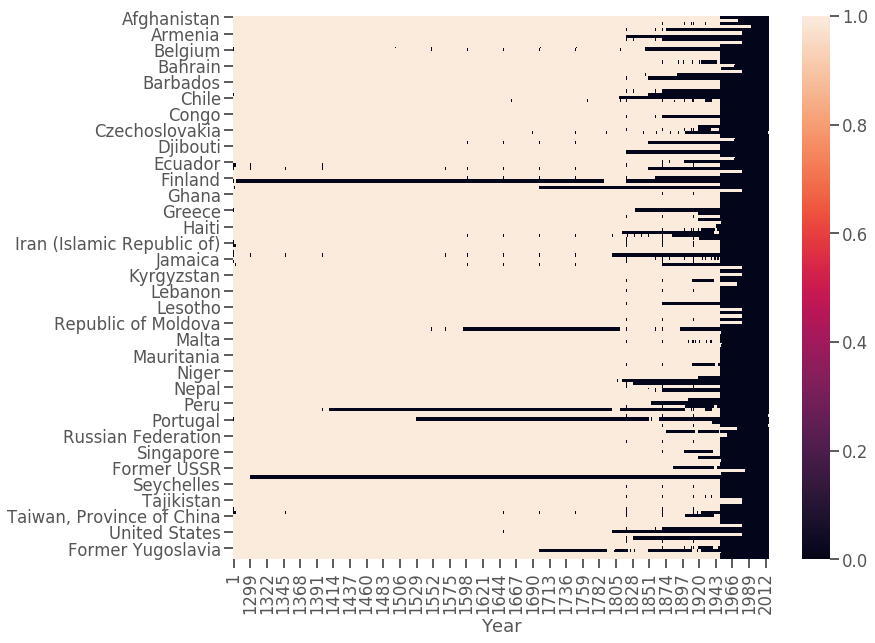

In [90]:
plt.figure(figsize=(12,10))
seaborn.heatmap(df.T.isna())

In [91]:
long_term_countries=df.query('Year<1800').isna().sum().sort_values().head(8).index

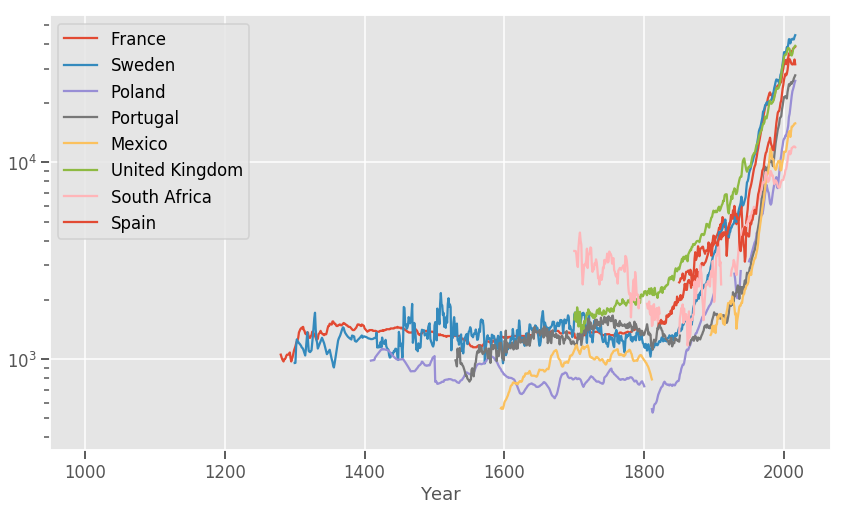

In [92]:
def plot_from(year,countries=long_term_countries,df=df,log=True):
    plt.figure(figsize=(14,8))
    if countries is not None:
        df=df[countries]
    df.query('Year>@year').plot(ax=plt.gca())
    if log:
        plt.yscale('log')
plot_from(1)

In [93]:
short_term_countries=df.query('Year>1820').isna().sum().sort_values().head(9).index

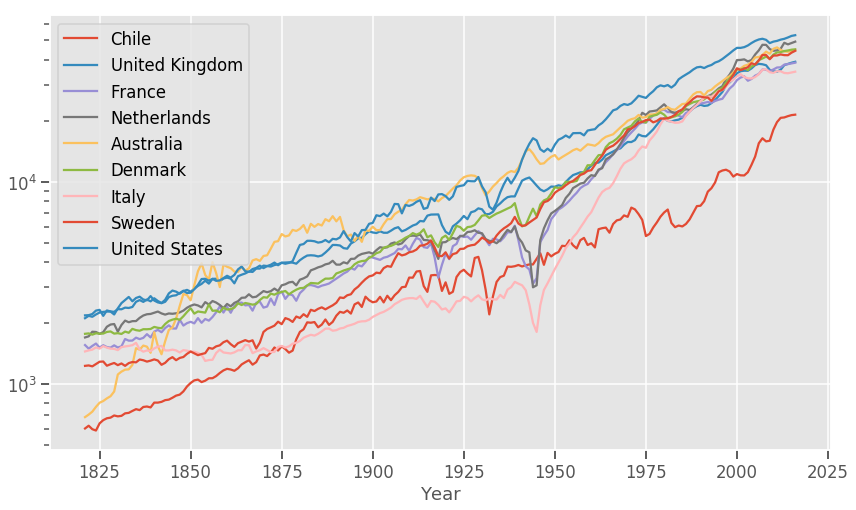

In [94]:
plot_from(1820,countries=short_term_countries)
assert (df[short_term_countries].loc[df.index>1820].isna().sum()==0).all()

In [95]:
df1=df[short_term_countries].loc[df.index>1820]

In [96]:
df1.pct_change().pipe(lambda x: x*100).describe()

,Chile,United Kingdom,France,Netherlands,Australia,Denmark,Italy,Sweden,United States
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,2.085232,1.540025,1.853172,1.938083,2.357178,1.741325,1.762172,1.913088,1.758165
std,6.892482,3.122010,6.378294,6.680173,6.332051,3.652067,4.912460,3.382565,4.312075
min,-24.417808,-11.454704,-20.550546,-32.841493,-14.722537,-14.376915,-18.899231,-9.179357,-15.106047
25%,-1.018897,-0.364232,-1.215928,-0.325060,-0.657270,0.124786,-0.625608,0.159363,-0.694883
50%,2.048702,1.673552,2.285969,1.632173,2.520265,1.869547,1.474531,2.092857,1.824025
75%,5.491995,3.479030,4.888368,3.813916,4.442560,3.434634,3.863819,3.831886,3.815295
max,23.382353,9.555345,50.494456,67.360885,29.116866,14.359887,35.417820,12.796504,13.593349


/home/jose/envs/env/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/jose/envs/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


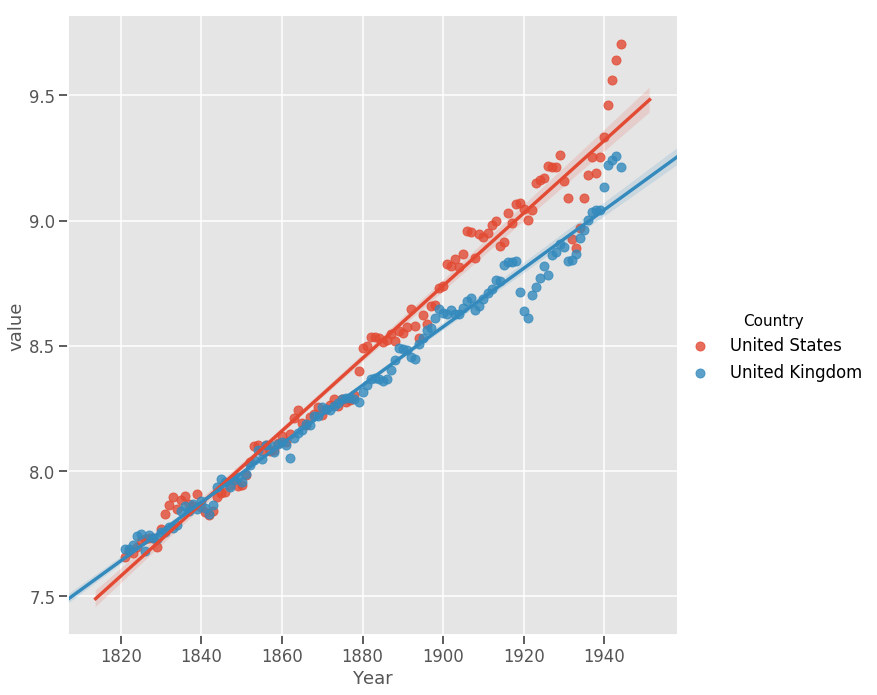

In [97]:
def plot_usuk(years):
    t=df1[['United States','United Kingdom']].astype(float).pipe(np.log).reset_index()
    t=t.query(years)
    t=t.melt(id_vars=['Year'],var_name='Country')
    seaborn.lmplot(x='Year',y='value',hue='Country',data=t,size=10)
plot_usuk('Year<1945')

/home/jose/envs/env/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


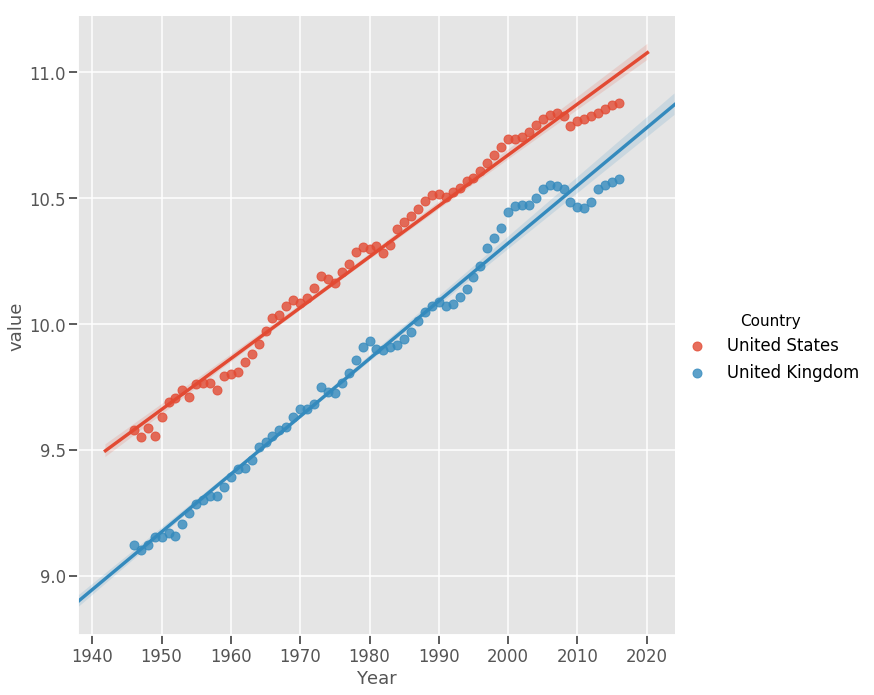

In [98]:
plot_usuk('Year>1945')

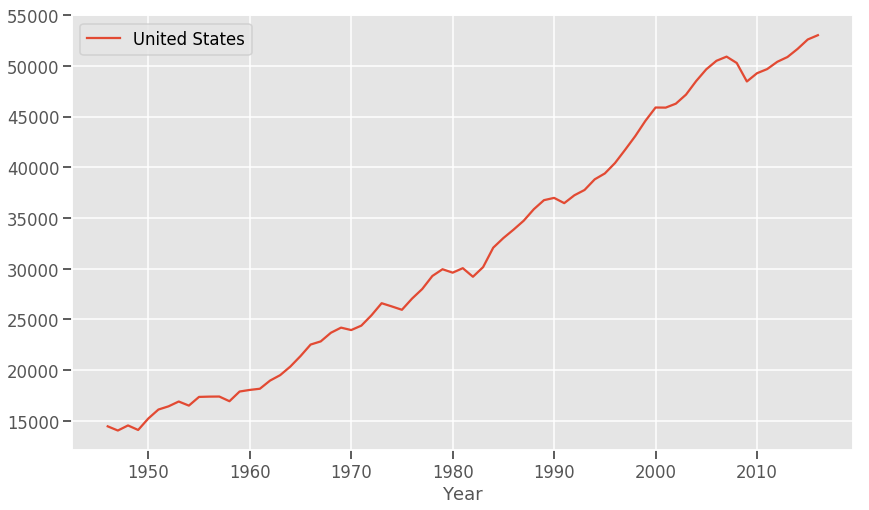

In [99]:
country='United States'
plot_from(1945,countries=[country],log=False)

/home/jose/envs/env/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


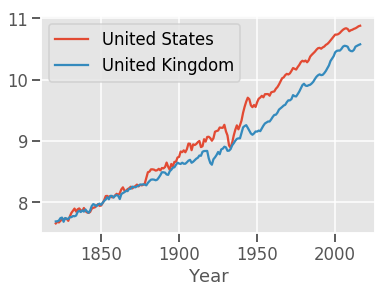

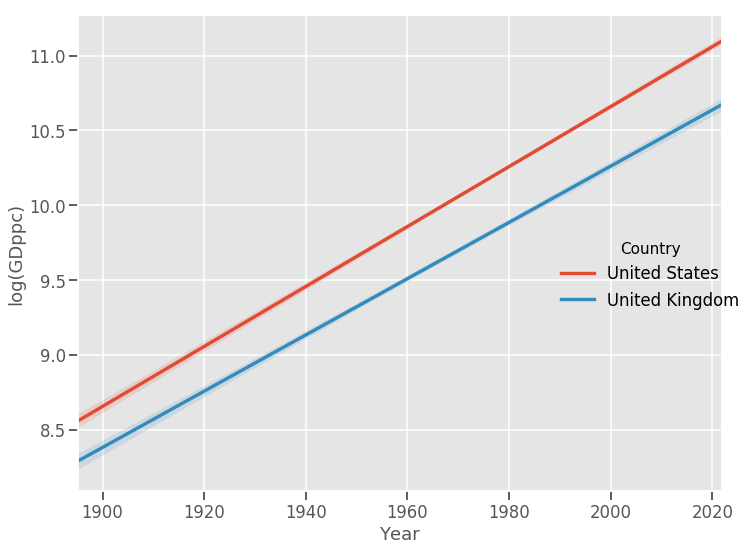

In [100]:
def plot_usuk_line(years):
    t=df1[['United States','United Kingdom']].astype(float).pipe(np.log).reset_index()
    t.set_index('Year').plot()
    t=t.query(years)
    t=t.melt(id_vars=['Year'],var_name='Country')
    seaborn.lmplot(x='Year',y='value',hue='Country',data=t,size=8,scatter=False)
plot_usuk_line('Year>1900')
plt.ylabel('log(GDppc)')
plt.tight_layout()
plt.savefig('GDP_1.png')

/home/jose/envs/env/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


France          1.000000
const_linear    0.992433
const_exp       0.989229
logi            0.989198
lin2            0.988456
Name: France, dtype: float64

'Regime switch at: 1884.6416999218834'

'Kink at: 1943.8326151146355'

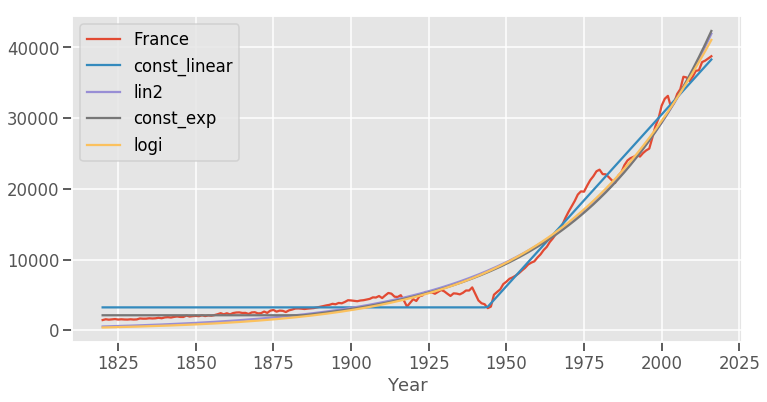

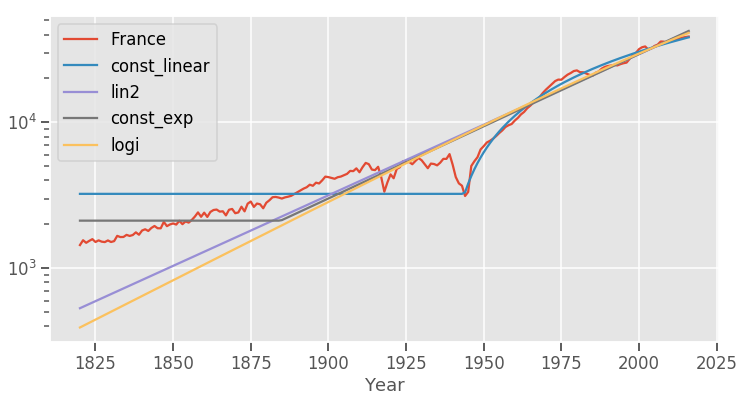

In [101]:
# Pick a bunch of years and you get linear beating exp
country='France'
t=df[[country]].reset_index().query('Year>1800').astype(float).dropna()
def linear(x,a,b):
    return a*x+b
def parabol(x,a,b,c):
    return a*x+b+c*x**2
def exp(x,a,b):
    return a*b**(x*0.01)
def log(x,a,b):
    return a+b*np.log(x)
def const_exp(x,const,exp0,switch):
    expval=exp(x,const/(exp0**(0.01*switch)),exp0)
    return np.where(x<switch,const,expval)
def const_lin(x,const,a,b):
    return np.maximum(const,a*x+b)
def const_lin2(x,a,exp0,exp1,t0):
    lin=x*a+(exp0*exp1**(0.01*t0)-a*t0)
    expg=exp(x,exp0,exp1)
    return np.where(x<t0,lin,expg)

def logistic_const(x,L,k,x0):
    s1=L/(1+np.exp(-k*(x-x0)))
    return s1

from scipy.optimize import curve_fit

coef,_=curve_fit(const_lin,t['Year'].values.squeeze(),t[country].values.squeeze())
t['const_linear']=const_lin(t['Year'],coef[0],coef[1],coef[2])
lincoef=coef




coef,_=curve_fit(exp,t['Year'].values.squeeze(),t[country].values.squeeze(),maxfev=100000)
#t['exp']=exp(t['Year'],coef[0],coef[1])

lin2coef,_=curve_fit(const_lin2,t['Year'].values.squeeze(),t[country].values.squeeze(),
                p0=[0,coef[0],coef[1],1800],maxfev=100000)
t['lin2']=const_lin2(t['Year'],lin2coef[0],lin2coef[1],lin2coef[2],lin2coef[3])



coef,_=curve_fit(const_exp,t['Year'].values.squeeze(),
                 t[country].values.squeeze(),maxfev=10000,p0=[1000,coef[1],1900])
t['const_exp']=const_exp(t['Year'],coef[0],coef[1],coef[2])
expcoef=coef

logcoef,_=curve_fit(logistic_const,t['Year'].values.squeeze(),t[country].values.squeeze(),
               maxfev=1000000,p0=[20000,0.01,1980])
t['logi']=logistic_const(t['Year'],*logcoef)


t.set_index('Year').plot(figsize=(12,6))
display(t.drop(columns='Year').corr()[country].sort_values(ascending=False))
display(f'Regime switch at: {expcoef[2]}')
kink=(lincoef[0]-lincoef[2])/lincoef[1]
display(f'Kink at: {kink}')
#print(f'Lin2 kinks at: {lin2coef[2],lin2coef[3]}')

display(t.set_index('Year').plot(figsize=(12,6)))
plt.yscale('log')
#TRy sum of exps

In [102]:
logcoef

array([1.93310731e+05, 2.49337715e-02, 2.06855610e+03])

In [103]:
df1[['United States']].pct_change().describe()

,United States
count,195.000000
mean,0.017582
std,0.043121
min,-0.151060
25%,-0.006949
50%,0.018240
75%,0.038153
max,0.135933


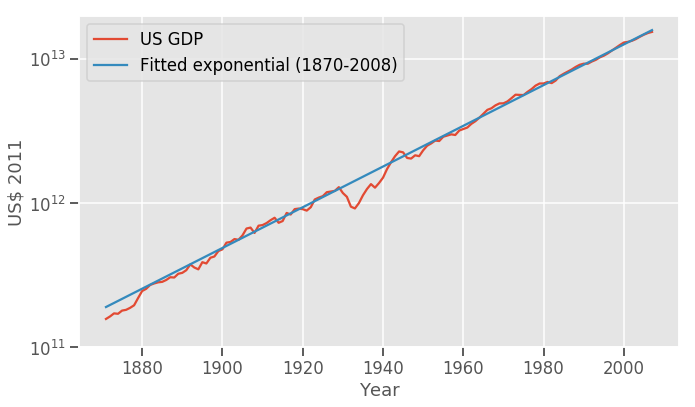

In [119]:
plt.style.use('ggplot')
seaborn.set_context('talk')
t=pd.concat([pop['United States'],df1['United States']],axis=1)
t.columns=['Population','GDPpc']
t=(
t.assign(GDP=t['GDPpc']*t['Population']*1000).dropna()
    .query('Year>1870 and Year<2008')
.astype(float)
    
.reset_index()
)
def plotval(x,legend,ylab,ticks=None):
    t.set_index('Year')[x].plot(figsize=(10,6))
    def exp(x,a,b):
        return a*b**(x*0.01)

    from scipy.optimize import curve_fit
    coef,_=curve_fit(exp,t['Year'].values.squeeze(),t[x].values.squeeze()/1e12,maxfev=100000,
                     p0=[1,1])


    plt.plot(t.Year,1e12*exp(t.Year,*coef))
    plt.yscale('log')
    from matplotlib.ticker import ScalarFormatter
    ax=plt.gca()


    plt.legend([legend,'Fitted exponential (1870-2008)'])
    plt.ylabel(ylab)
    plt.yticks(ticks)
    plt.minorticks_off()
    plt.tight_layout()

    plt.savefig(f'{x}1.png')
plotval('GDP','US GDP','US$ 2011',[10**11,10**12,10**13])

In [121]:
t.pct_change().describe()

,Year,Population,GDPpc,GDP
count,136.000000,136.000000,136.000000,136.000000
mean,0.000516,0.014783,0.020337,0.035402
std,0.000010,0.005190,0.047670,0.048235
min,0.000499,0.004907,-0.151060,-0.145591
25%,0.000507,0.010090,-0.004345,0.011071
50%,0.000516,0.013976,0.021291,0.035358
75%,0.000525,0.019295,0.044577,0.060522
max,0.000534,0.025467,0.135933,0.146939


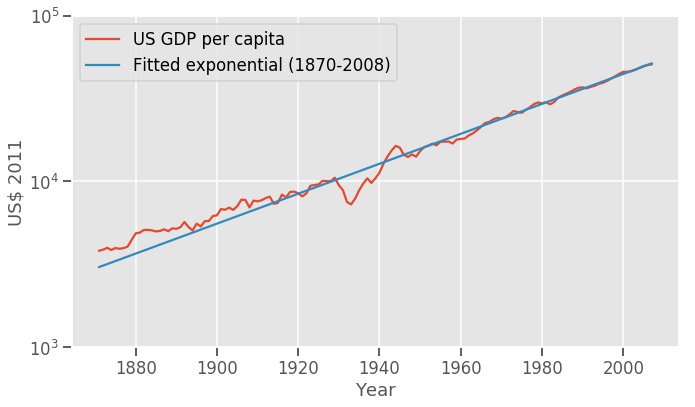

In [105]:
plotval('GDPpc','US GDP per capita','US$ 2011',[10**3,10**4,10**5])

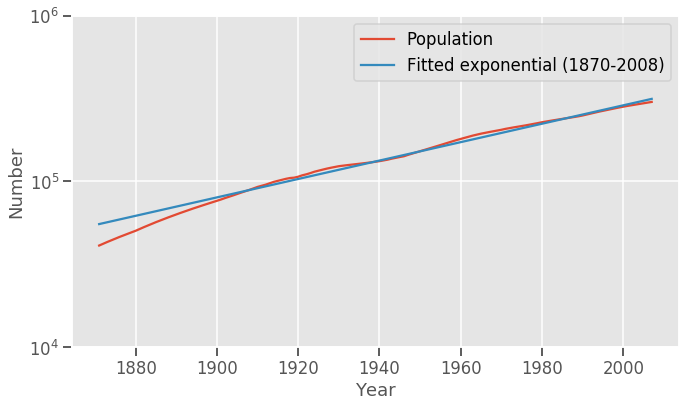

In [106]:
plotval('Population','Population','Number',[10**4,10**5,10**6])

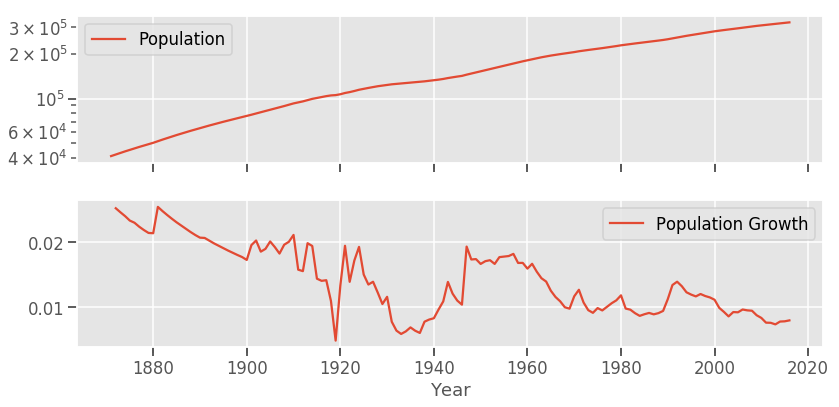

In [107]:
t=pd.concat([pop['United States'],df1['United States']],axis=1)
t.columns=['Population','GDPpc']
t=(t
#t.assign(GDP=t['GDPpc']*t['Population']*1000).dropna()
.query('Year>1870')
.Population
.astype(float)
    
.reset_index()
)

t['Population Growth']=t.Population.pct_change()
t=t.set_index('Year')
plt.figure(figsize=(12,6))
ax=plt.subplot(2,1,1)
t[['Population']].plot(ax=plt.gca())
plt.yscale('log')
plt.subplot(2,1,2,sharex=ax)
t[['Population Growth']].plot(ax=plt.gca())
plt.tight_layout()
plt.savefig('pop_growth_compare.png')

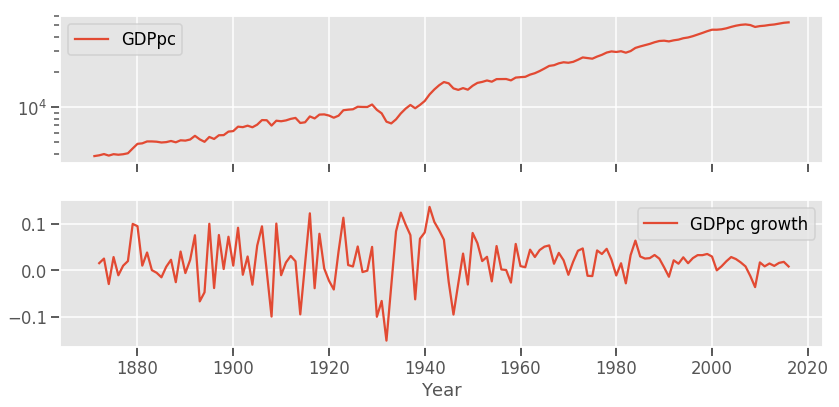

In [108]:
t=pd.concat([pop['United States'],df1['United States']],axis=1)
t.columns=['Population','GDPpc']
t=(t
#t.assign(GDP=t['GDPpc']*t['Population']*1000).dropna()
.query('Year>1870')
.GDPpc
.astype(float)
    
.reset_index()
)

t['GDPpc growth']=t.GDPpc.pct_change()
t=t.set_index('Year')
plt.figure(figsize=(12,6))
ax=plt.subplot(2,1,1)
t[['GDPpc']].plot(ax=plt.gca())
plt.yscale('log')
plt.subplot(2,1,2,sharex=ax)
t[['GDPpc growth']].plot(ax=plt.gca())
plt.tight_layout()
plt.savefig('gdp_growth_compare.png')

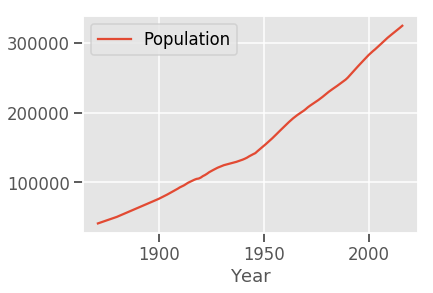

In [109]:
t=pd.concat([pop['United States'],df1['United States']],axis=1)
t.columns=['Population','GDPpc']
t=(t
#t.assign(GDP=t['GDPpc']*t['Population']*1000).dropna()
.query('Year>1870')
   .Population
.astype(float)
    
.reset_index()
)
t.set_index('Year').plot()

In [110]:
country='Sweden'
t=pd.concat([pop[country],df[country]],axis=1)
t.columns=['Population','GDPpc']
t=(
t.assign(GDP=t['GDPpc']*t['Population']*1000).dropna()

.astype(float)
    
.reset_index()
)
t.set_index('Year')

,Population,GDPpc,GDP
Year,,,
1500,550.0,1482.0,8.151000e+08
1600,760.0,1060.0,8.056000e+08
1700,1260.0,1687.0,2.125620e+09
1820,2573.0,1192.0,3.067016e+09
1821,2598.0,1228.0,3.190344e+09
1822,2629.0,1234.0,3.244186e+09
1823,2668.0,1221.0,3.257628e+09
1824,2708.0,1254.0,3.395832e+09
1825,2749.0,1287.0,3.537963e+09


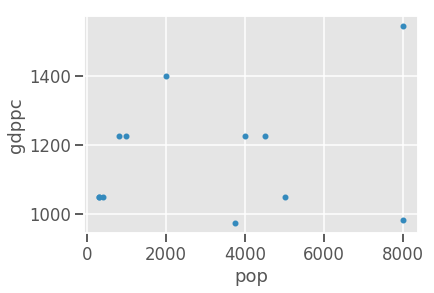

In [111]:
pop_m=pop.reset_index().melt(id_vars='Year',value_name='pop').dropna()
gdp_m=df.reset_index().melt(id_vars='Year',value_name='gdppc').dropna()
t=pd.merge(pop_m,gdp_m,on=['Year','variable'])
t['gdp']=t['pop']*t['gdppc']
t['gdppc_g']=t.gdppc.pct_change()
t['pop_g']=t['pop'].pct_change()
#t=t.query('variable=="Sweden"')
t.sort_values(['Year','gdppc']).query('Year==1')[['pop','gdppc']].astype(float).plot.scatter('pop','gdppc')

In [112]:
t.gdppc.pct_change()

0             NaN
1        0.012542
2        0.016515
3        0.043054
4        0.003115
5        0.001165
6        0.025204
7       -0.019289
8        0.035094
9        0.007824
10       0.014418
11      -0.013120
12      -0.004801
13      -0.004453
14      -0.003727
15      -0.001122
16      -0.013858
17       0.003418
18       0.010598
19      -0.008989
20      -0.005291
21      -0.027356
22      -0.185156
23       0.002397
24       0.027738
25       0.035365
26       0.027416
27      -0.074366
28       0.046786
29      -0.043792
           ...   
14699   -0.071306
14700    0.029911
14701    0.008683
14702   -0.030870
14703    0.004594
14704   -0.132622
14705   -0.033743
14706    0.059658
14707   -0.024717
14708    0.067230
14709   -0.006266
14710   -0.002323
14711   -0.038922
14712   -0.066805
14713   -0.026706
14714   -0.094512
14715   -0.175926
14716   -0.074055
14717   -0.084391
14718   -0.043976
14719   -0.040958
14720   -0.172142
14721    0.054762
14722    0.072235
14723    0

In [113]:
#TFP
link='http://www.longtermproductivity.com/download/BCLDatabase_online_v2.0.xlsx'
file=requests.get(link)
with BytesIO(file.content) as TFP:
    
    tfp=pd.read_excel(TFP,sheet_name='TFP')
tfp=tfp.iloc[:,:-2].dropna(how='all')  
country='USA'

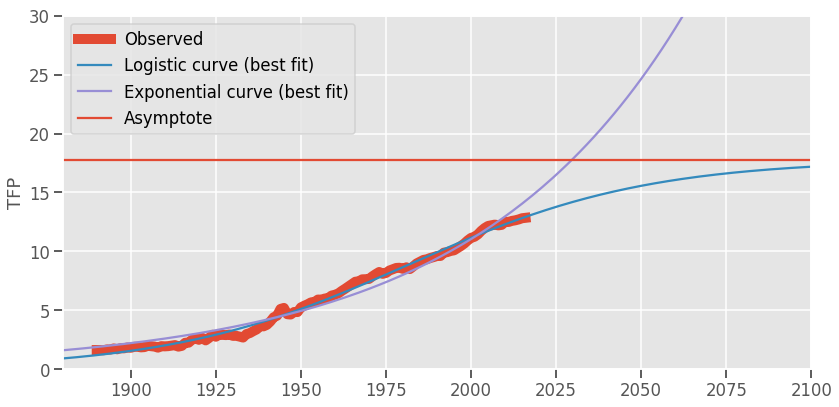

In [114]:
country='USA'
t=tfp[[country]].copy()


def logistic(x,L,k,x0):
    s1=L/(1+np.exp(-k*(x-x0)))
    return s1



from scipy.optimize import curve_fit

coef,_=curve_fit(logistic,t.index.values.squeeze(),t[country].values.squeeze(),
                maxfev=10000,p0=[14,0.05,1900])
coef2,_=curve_fit(exp,t.index.values.squeeze(),t[country].values.squeeze(),
                maxfev=10000)
idx=np.arange(0,2200)


pred=pd.DataFrame({'Logistic curve (best fit)':logistic(idx,*coef),
                  'Exponential curve (best fit)':exp(idx,*coef2)},index=idx)
#pred=pd.DataFrame({'predicted':logistic(idx,L,k,x0)},index=idx)
t2=pd.concat([t,pred],axis=1)


plt.figure(figsize=(12,6))
t2[country].plot(linewidth=10,label='Observed')
t2.drop(columns=country).plot(ax=plt.gca())
plt.axhline(coef[0],label='Asymptote')
plt.xlim([1880,2100])
plt.ylim([0,30])
plt.legend()
plt.ylabel('TFP')
plt.tight_layout()
plt.savefig('TFP_asymptote.png')
#http://accelerating.org/articles/InnovationHuebnerTFSC2005.pdf

In [115]:
coef

array([1.77689046e+01, 2.86149939e-02, 1.98165149e+03])

(0, 80000)

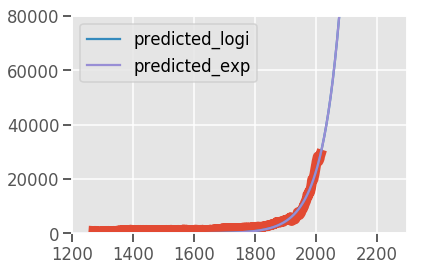

In [116]:
t=pd.read_csv('millenium_boe_a21.csv').set_index('Year')

country='GDPpc'
def logistic(x,L,k,x0):
    s1=L/(1+np.exp(-k*(x-x0)))
    return s1



from scipy.optimize import curve_fit

coef,_=curve_fit(logistic,t.index.values.squeeze(),t[country].values.squeeze(),
                maxfev=100000,p0=[10000,1,1900])
coef2,_=curve_fit(exp,t.index.values.squeeze(),t[country].values.squeeze(),
                maxfev=100000)
idx=np.arange(0,2300)


pred=pd.DataFrame({'predicted_logi':logistic(idx,*coef),
                  'predicted_exp':exp(idx,*coef2)},index=idx)
#pred=pd.DataFrame({'predicted':logistic(idx,L,k,x0)},index=idx)
t2=pd.concat([t,pred],axis=1)



t2[country].plot(linewidth=10)
t2.drop(columns=country).plot(ax=plt.gca())
plt.xlim([1200,2300])
plt.ylim([0,80000])


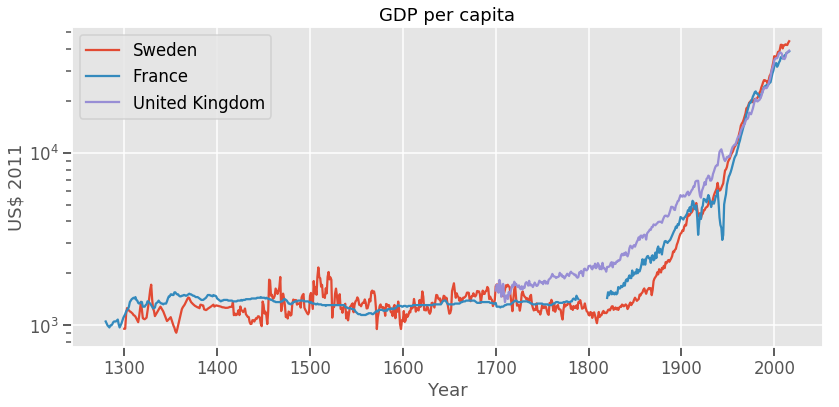

In [117]:
plt.figure(figsize=(12,6))
df[['Sweden','France','United Kingdom']].query('Year>1250').plot(ax=plt.gca())
plt.yscale('log')
plt.title('GDP per capita')
plt.ylabel('US$ 2011')
plt.tight_layout()
plt.savefig('longrun.png')

In [118]:
t['Population Growth'].plot()

KeyError: 'Population Growth'

In [ ]:
100*t['Population Growth'].iloc[-1]